In [1]:
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from colour import Color

import nltk  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer 
#from nltk.corpus import wordnet

from flair.models import TextClassifier
from flair.data import Sentence
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import plotly.offline as offline
offline.init_notebook_mode(connected=True)

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wslin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wslin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wslin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wslin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
lemmatizer = WordNetLemmatizer()
stopword = set(stopwords.words('english'))
sia = TextClassifier.load('en-sentiment')

2022-04-14 17:40:52,767 loading file C:\Users\wslin\.flair\models\sentiment-en-mix-distillbert_4.pt


In [4]:
df = pd.read_csv('./conspiracy_theories_data.csv')
df

,id,date,search,tweet,tidyTweet
0,1484309873059934208,2022-01-20 15:40:25,#americafirst,@77WABCradio @RudyGiuliani I suppose all the e...,"I suppose all the election fraud, the Biden ..."
1,1484309738808840192,2022-01-20 15:39:53,#americafirst,The press had a lot of questions about Ukraine...,The press had a lot of questions about Ukraine...
2,1484309298867933186,2022-01-20 15:38:08,#americafirst,"Nevada, vote for the candidate who has the rig...","Nevada, vote for the candidate who has the rig..."
3,1484307683532754944,2022-01-20 15:31:43,#americafirst,@POTUS PLEASE TAKE ACTION AND ABOLISH YOUR TRU...,PLEASE TAKE ACTION AND ABOLISH YOUR TRUTH IN ...
4,1484306314432032768,2022-01-20 15:26:17,#americafirst,#Trump Backs Banning #NancyPelosi from #StockT...,#Trump Backs Banning #NancyPelosi from #StockT...
...,...,...,...,...,...
12084,1502623553891741701,2022-03-12 04:32:27,#wheresfauci,@MusicManVA 🐸🐷 Missing❗️ 🌸 #WheresFauci??? ...,🐸🐷 Missing❗️ 🌸 #WheresFauci??? 😆
12085,1502623511592173570,2022-03-12 04:32:17,#wheresfauci,🐸🐷 Missing❗️ 🌸 #WheresFauci??? 😆 https://...,🐸🐷 Missing❗️ 🌸 #WheresFauci??? 😆
12086,1502621900618489856,2022-03-12 04:25:53,#wheresfauci,#WheresFauci ?? His stubby little fingerprin...,#WheresFauci ?? His stubby little fingerprin...
12087,1502607009652293634,2022-03-12 03:26:42,#wheresfauci,good morning...#WheresFauci,good morning...#WheresFauci


In [5]:
def clean_tweet(s):
    s = str(s).lower()
    url_pattern = re.compile(r'https?://\S+')
    no_url = url_pattern.sub(r'', s)
    username_pattern = re.compile(r'@\w+')
    no_username = username_pattern.sub(r'', no_url)
    hashtag_pattern = re.compile(r'#')
    no_hashtag = hashtag_pattern.sub(r'', no_username)
    punct_pattern = re.compile(r'[^\w\s\']')
    no_punct = punct_pattern.sub(r'', no_hashtag)
    amp_pattern = re.compile(r'&amp;')
    tidy_tweet = amp_pattern.sub(r'and', no_punct)
    return tidy_tweet

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def normalize_words(tokens):
    norm_tokens = [lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return norm_tokens

def remove_stopwords(tokens):
    result_tokens = []
    for t in tokens:
        if (t not in stopword and len(t) > 2 and not t.isnumeric() and t.isalpha()):
            result_tokens.append(t)
    return result_tokens

def combine_tokens(tokens): 
    non_tokenized = ' '.join([t for t in tokens])
    return non_tokenized

def tweets_preprocessing(tweet):
    tidy_tweet = clean_tweet(tweet)
    tokens = nltk.word_tokenize(tidy_tweet)
    norm_tokens = normalize_words(tokens)
    result_tokens = remove_stopwords(norm_tokens)
    non_tokenized = combine_tokens(result_tokens)
    return non_tokenized if len(non_tokenized) != 0 else np.nan

In [6]:
def sentiment_Flair_score(tweet):
    sentence = Sentence(tweet)
    sia.predict(sentence)
    if 'NEGATIVE' in str(sentence.labels[0]):
        score = -(sentence.labels[0].score)
    else:
        score = sentence.labels[0].score
    return score

def sentiment_Vader_score(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    compound_score = score['compound']
    return compound_score

def sentiment_analysis(score):
    if score >= 0:
        return 'positive'
    else:
        return 'negative'

In [7]:
def get_sentiment_analysis(df):
    df['tidyTweet'] = df['tweet'].apply(tweets_preprocessing)
    df = df.dropna(subset=['tidyTweet']).reset_index(drop=True)
    df['flair_score'] = df['tidyTweet'].apply(sentiment_Flair_score)
    df['sentiment_flair'] = df['flair_score'].apply(sentiment_analysis)

    df['vader_score'] = df['tidyTweet'].apply(sentiment_Vader_score)
    df['sentiment_vader'] = df['vader_score'].apply(sentiment_analysis)
    return df

In [8]:
df = pd.read_csv('./conspiracy_theories_data.csv')
df = get_sentiment_analysis(df)

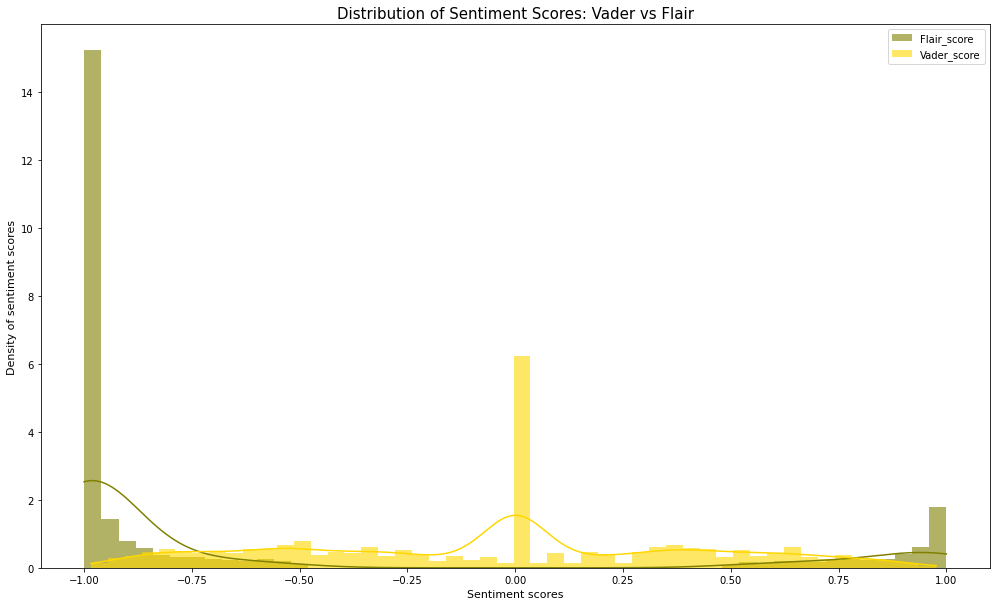

In [9]:
fig1 = plt.figure(figsize=(17,10))

sns.histplot(df['flair_score'], kde=True, color="olive", stat="density", bins=50, alpha=0.6, linewidth=0, label='Flair_score')
sns.histplot(df['vader_score'], kde=True, color="gold", stat="density", bins=50, alpha=0.6, linewidth=0, label='Vader_score')

plt.legend(fontsize=10)
plt.title('Distribution of Sentiment Scores: Vader vs Flair', fontsize=15)
plt.ylabel('Density of sentiment scores', fontsize=11)
plt.xlabel('Sentiment scores', fontsize=11)

plt.show()
fig1.savefig('libraries_distribution.png')

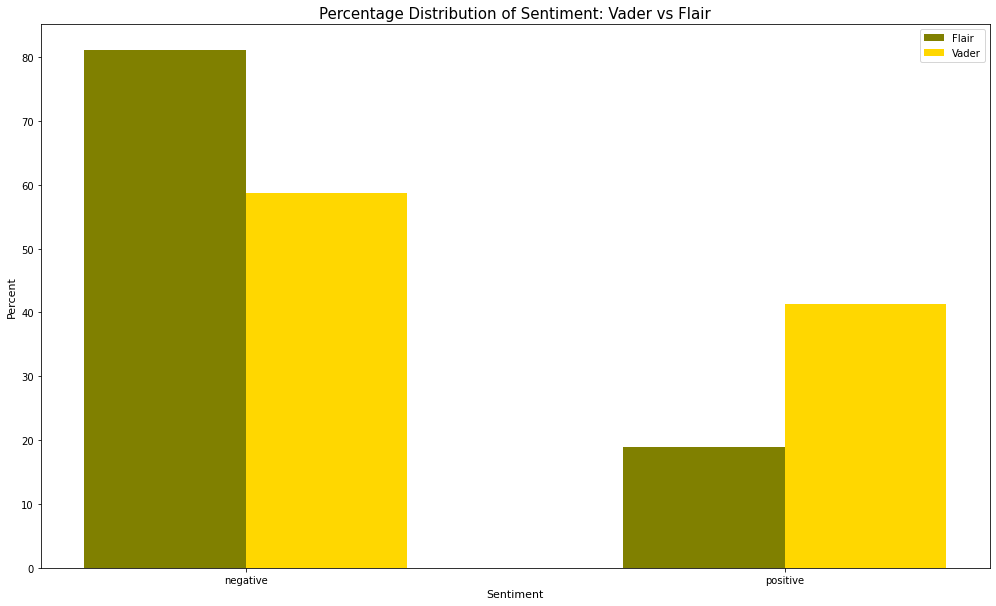

In [10]:
flair_percent = (df['sentiment_flair'].value_counts()/len(df['sentiment_flair']))*100
vader_percent = (df['sentiment_vader'].value_counts()/len(df['sentiment_vader']))*100

fig2 = plt.figure(figsize=(17,10))
x_axis = np.arange(2)

plt.bar(x_axis-0.15, flair_percent, label='Flair', width=0.3, color='olive')
plt.bar(x_axis+0.15, vader_percent, label='Vader', width=0.3, color='gold')

plt.xticks(x_axis, df['sentiment_flair'].value_counts().index)
plt.legend(fontsize=10)
plt.title('Percentage Distribution of Sentiment: Vader vs Flair', fontsize=15)
plt.ylabel('Percent', fontsize=11)
plt.xlabel('Sentiment', fontsize=11)

plt.show()
fig2.savefig('libraries_percent.png')

In [11]:
df['diff'] = np.where(df['sentiment_flair'] == df['sentiment_vader'], 1, 0)
df_diff = df.query('diff == 0')
great_diff = df_diff.loc[(df_diff['flair_score'].abs() > 0.9) & (df_diff['vader_score'].abs() > 0.90)]
great_diff = great_diff [['tweet', 'sentiment_flair', 'sentiment_vader']]

In [12]:
for t in great_diff['tweet']:
    print(t)
    print('\n')

If you need a lawyer, do you hire the best, or trust the public defender. If you HAVE to send secure pkg, use FedEx or postal service?..so WHY WOULD YOU TRUST A GOVT FRAUD OVER BRILLIANT PRIVATE DOCTORS? #Covid_19 #MandateFreedom #NHS #FauciLied @RandPaul @BuckSexton @ClayTravis


Who else loves America??  This is the GREATEST COUNTRY on the planet!!   The anti-American ideologues should move to any other Country on earth. Just choose one. You will beg to get back to America.   Don’t let them take America away.  We are America. Respect it. #AmericaFirst  https://t.co/IJ9PWTpIOY


Wow @Spotify glad I don’t use you.  You keep an #Antivaxxer like Joe Rogan and delete a national treasure like Neil Young?  #DumpSpotify #BoycottSpotify


It’s absolutely no wonder that #QAnon &amp; the #GOP are so focused on child sexual abuse &amp; #childtrafficking they are the predators &amp; the perpetrators of these crimes. Those that scream the loudest are usually the guilty parties. #GOPHypocrisy


So 

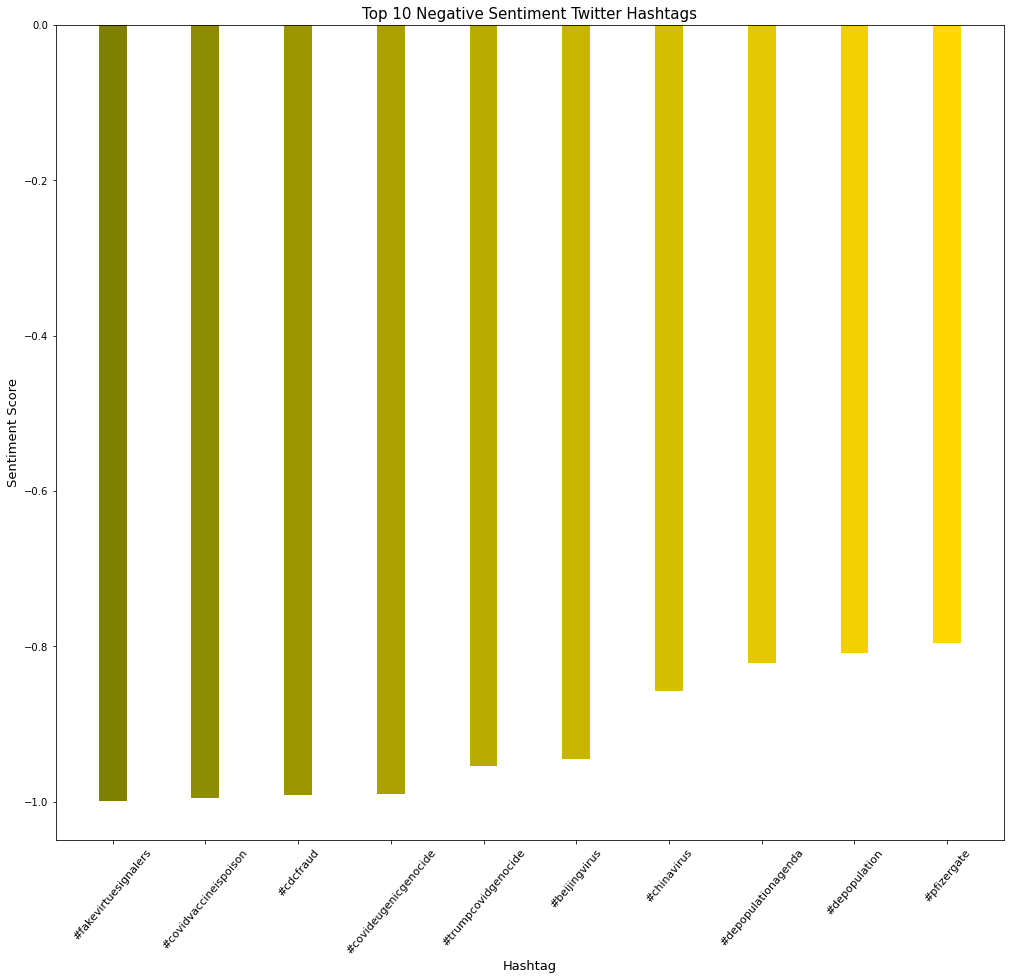

In [13]:
df1 = df.groupby('search')['flair_score'].mean().sort_values().head(10).to_frame().reset_index()

fig5 = plt.figure(figsize=(17,15))

olive = Color("olive")
colors = list(olive.range_to(Color("gold"), 10))
colors = [color.rgb for color in colors]

plt.bar(df1['search'], df1['flair_score'], width=0.3, color=colors)

plt.title('Top 10 Negative Sentiment Twitter Hashtags', fontsize=15)
plt.ylabel('Sentiment Score', fontsize=13)
plt.xlabel('Hashtag', fontsize=13)
plt.xticks(rotation=50, fontsize=11)

plt.show()
fig5.savefig('top10.png')

In [14]:
df2 = pd.read_excel("month.xlsx")

In [15]:
def get_datetime(df):
    df['date_notime'] = df['date'].str.split(' ', expand=True,)[0]
    df3 = df.groupby('date_notime')['flair_score'].describe()
    df3['datetime'] = df3.index
    return df3

In [16]:
df3 = get_datetime(df)

In [17]:
def get_avg_std_graph(df3, name):
    fig = plt.figure(figsize=(17,10))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.3)
    ax_1_1 = fig.add_subplot(2,1,1)
    ax_1_1.bar(df3['datetime'], df3['mean'], width=0.5, label='mean', color='olive') 
    ax_1_1.set_title(r'Average and Standard Deviation of Sentiment Scores by Date', fontsize=15)
    ax_1_1.set_ylabel(r'Average', fontsize=11)
    ax_1_1.tick_params(axis='x', labelrotation=50, size=6, direction='inout')

    ax_1_2 = fig.add_subplot(2,1,2)
    ax_1_2.bar(df3['datetime'], df3['std'], width=0.5, label='std', color='gold')
    ax_1_2.set_ylabel(r'Standard Deviation', fontsize=11)
    ax_1_2.tick_params(axis='x', labelrotation=50, size=6, direction='inout')

    fig.savefig(name+'_mean&std.png')   

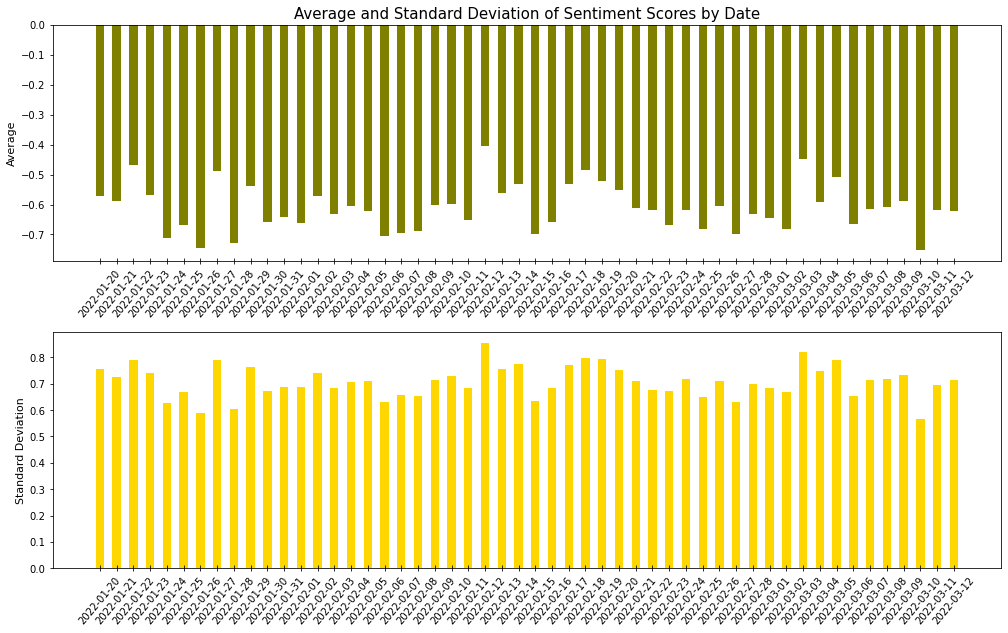

In [18]:
get_avg_std_graph(df3, 'conspiracy')

In [19]:
def get_month(df2, df3):
    df4 = pd.merge(df2, df3, how = "outer")
    df4['day'] = df4['datetime'].apply(lambda x: pd.to_datetime(x).strftime("%A"))
    df4['month'] = df4['datetime'].str.slice(5, 7)

    df_jan = df4[df4['month'] == '01']
    df_feb = df4[df4['month'] == '02']
    df_mar = df4[df4['month'] == '03']
    return df_jan, df_feb, df_mar

In [20]:
df_jan, df_feb, df_mar = get_month(df2, df3)

In [21]:
def get_calender_graph(df_jan, df_feb, df_mar, name, vmin, vmax):
    fig4, (ax_2_1, ax_2_2, ax_2_3) = plt.subplots(figsize=(17,10), nrows = 3)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.4)

    column_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

    pivot1 = df_jan.pivot(index='week_num', columns='day', values='mean')
    pivot1 = pivot1.reindex(column_order, axis=1)
    sns.heatmap(pivot1, annot=True, cmap='YlGnBu_r', ax=ax_2_1, vmin=vmin, vmax=vmax)
    ax_2_1.set_title('January', fontsize=15)

    pivot2 = df_feb.pivot(index='week_num', columns='day', values='mean')
    pivot2 = pivot2.reindex(column_order, axis=1)
    sns.heatmap(pivot2, annot=True, cmap='YlGnBu_r', ax=ax_2_2, vmin=vmin, vmax=vmax)
    ax_2_2.set_title('February',  fontsize=15)

    pivot3 = df_mar.pivot(index='week_num', columns='day', values='mean')
    pivot3 = pivot3.reindex(column_order, axis=1)
    sns.heatmap(pivot3, annot=True, cmap='YlGnBu_r', ax=ax_2_3, vmin=vmin, vmax=vmax)
    ax_2_3.set_title('March',  fontsize=15)

    fig4.savefig(name+'_calendar.png')  

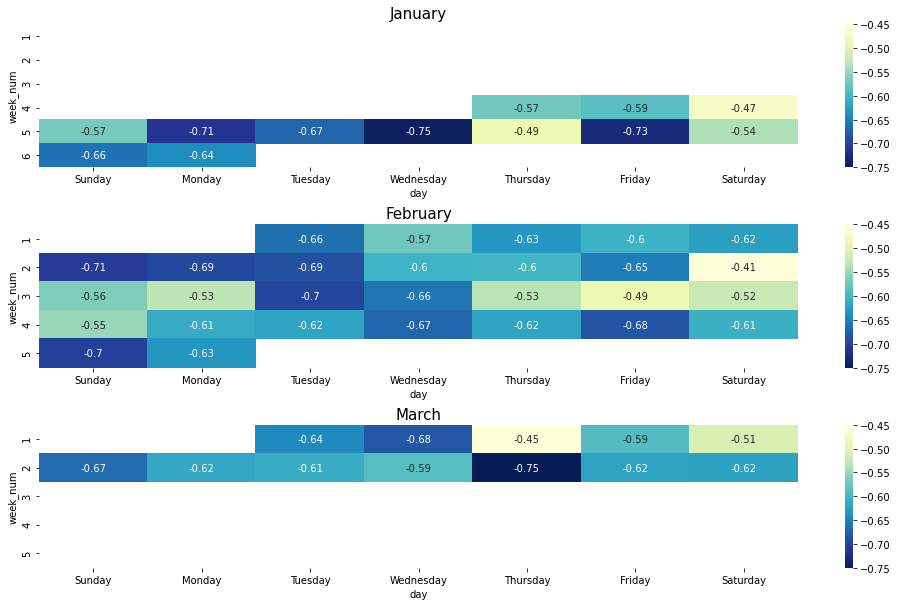

In [22]:
get_calender_graph(df_jan, df_feb, df_mar, 'conspiracy', -0.45, -0.75)

In [23]:
def labeled_df(file):
    df = pd.read_csv(file)
    df = df[df['Label'].notna()]
    df = get_sentiment_analysis(df)
    df['sentiment'] = df['sentiment_flair'].apply(
        lambda x: (0 if x == 'positive' else 1)
    )
    return df

def prediction_sentiment_figure(labeled_df):
    df_flair = pd.get_dummies(
        labeled_df[['Label', 'sentiment_flair']],
        columns=['sentiment_flair']
    )
    df_flair = df_flair.groupby('Label').sum()
    labels = ['Negative', 'Positive']
    fig = make_subplots(
        1, 2, specs=[[{'type':'domain'}, {'type':'domain'}]],
        subplot_titles=['Prediction: 0', 'Prediction: 1']
    )
    fig.add_trace(
        go.Pie(
            labels=labels, values=df_flair.loc[0],
            name="Label 0"
        ), 1, 1
    )
    fig.add_trace(
        go.Pie(
            labels=labels, values=df_flair.loc[1],
            name='Label 1'
        ), 1, 2
    )
    return fig

In [24]:
labeled_data = labeled_df('./dataset.csv')

In [27]:
pred_senti_fig = prediction_sentiment_figure(labeled_data)
offline.iplot(pred_senti_fig)

In [28]:
table = pd.crosstab(labeled_data['Label'], labeled_data['sentiment_flair']) 
chi2, p, dof, expected = chi2_contingency(table) 

In [29]:
print(p)

3.2830806552835724e-11
